# ARIMA Forecasting Model for Azure Cost Management

This notebook implements ARIMA (AutoRegressive Integrated Moving Average) forecasting models for Azure cost prediction. ARIMA is a classical time series forecasting method that works well for stationary time series.

## ARIMA Model Features
- **AR (AutoRegressive)**: Uses past values to predict future values
- **I (Integrated)**: Handles non-stationary data through differencing
- **MA (Moving Average)**: Uses past forecast errors to predict future values
- **Automatic Parameter Selection**: Uses statistical tests to find optimal parameters
- **Seasonal ARIMA (SARIMA)**: Handles seasonal patterns

## Objectives
1. Load and prepare time series data for ARIMA
2. Perform stationarity tests and transformations
3. Find optimal ARIMA parameters using auto_arima
4. Train ARIMA models for different cost categories
5. Generate forecasts with confidence intervals
6. Evaluate model performance and compare with Prophet


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# ARIMA specific imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from pmdarima import auto_arima
from pmdarima.arima import ARIMA as PMDARIMA
import statsmodels.api as sm

# Load forecasting data
import pickle
with open('/Users/sabbineni/projects/acm/data/forecasting_data.pkl', 'rb') as f:
    forecasting_data = pickle.load(f)

print("Libraries imported successfully!")
print(f"Available time series: {list(forecasting_data.keys())}")

# Display data info
for key, ts_data in forecasting_data.items():
    print(f"{key}: {len(ts_data)} data points, "
          f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")


Libraries imported successfully!
Available time series: ['Analytics', 'Network', 'Storage', 'Security', 'Management', 'Database', 'Compute', 'AI/ML', 'Total']
Analytics: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Network: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Storage: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Security: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Management: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Database: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Compute: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
AI/ML: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Total: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00


In [2]:
# Stationarity Tests and Data Preparation
def test_stationarity(timeseries, title="Time Series"):
    """
    Perform stationarity tests on time series data.
    """
    print(f"\n=== Stationarity Tests for {title} ===")
    
    # ADF Test
    adf_result = adfuller(timeseries.dropna())
    print(f"ADF Test:")
    print(f"  ADF Statistic: {adf_result[0]:.6f}")
    print(f"  p-value: {adf_result[1]:.6f}")
    print(f"  Critical Values:")
    for key, value in adf_result[4].items():
        print(f"    {key}: {value:.6f}")
    
    if adf_result[1] <= 0.05:
        print("  ✅ Series is stationary (reject null hypothesis)")
    else:
        print("  ❌ Series is non-stationary (fail to reject null hypothesis)")
    
    # KPSS Test
    try:
        kpss_result = kpss(timeseries.dropna(), regression='c')
        print(f"\nKPSS Test:")
        print(f"  KPSS Statistic: {kpss_result[0]:.6f}")
        print(f"  p-value: {kpss_result[1]:.6f}")
        print(f"  Critical Values:")
        for key, value in kpss_result[3].items():
            print(f"    {key}: {value:.6f}")
        
        if kpss_result[1] >= 0.05:
            print("  ✅ Series is stationary (fail to reject null hypothesis)")
        else:
            print("  ❌ Series is non-stationary (reject null hypothesis)")
    except:
        print("  ⚠️ KPSS test failed (insufficient data or other issue)")

def make_stationary(timeseries, method='diff'):
    """
    Make time series stationary using differencing or log transformation.
    """
    if method == 'diff':
        return timeseries.diff().dropna()
    elif method == 'log_diff':
        return np.log(timeseries + 1).diff().dropna()
    elif method == 'log':
        return np.log(timeseries + 1)
    else:
        return timeseries

# Test stationarity for key categories
key_categories = ['Total', 'Compute', 'Storage', 'Database']
stationarity_results = {}

for category in key_categories:
    if category in forecasting_data:
        ts_data = forecasting_data[category]
        test_stationarity(ts_data, category)
        
        # Try different transformations
        print(f"\n--- Testing transformations for {category} ---")
        
        # Original data
        test_stationarity(ts_data, f"{category} (Original)")
        
        # First difference
        diff_data = make_stationary(ts_data, 'diff')
        if len(diff_data) > 10:
            test_stationarity(diff_data, f"{category} (1st Diff)")
        
        # Log transformation
        log_data = make_stationary(ts_data, 'log')
        test_stationarity(log_data, f"{category} (Log)")
        
        # Log + First difference
        log_diff_data = make_stationary(ts_data, 'log_diff')
        if len(log_diff_data) > 10:
            test_stationarity(log_diff_data, f"{category} (Log + 1st Diff)")
        
        stationarity_results[category] = {
            'original': ts_data,
            'diff': diff_data if len(diff_data) > 10 else None,
            'log': log_data,
            'log_diff': log_diff_data if len(log_diff_data) > 10 else None
        }



=== Stationarity Tests for Total ===
ADF Test:
  ADF Statistic: -2.117293
  p-value: 0.237618
  Critical Values:
    1%: -3.449065
    5%: -2.869786
    10%: -2.571163
  ❌ Series is non-stationary (fail to reject null hypothesis)

KPSS Test:
  KPSS Statistic: 0.823171
  p-value: 0.010000
  Critical Values:
    10%: 0.347000
    5%: 0.463000
    2.5%: 0.574000
    1%: 0.739000
  ❌ Series is non-stationary (reject null hypothesis)

--- Testing transformations for Total ---

=== Stationarity Tests for Total (Original) ===
ADF Test:
  ADF Statistic: -2.117293
  p-value: 0.237618
  Critical Values:
    1%: -3.449065
    5%: -2.869786
    10%: -2.571163
  ❌ Series is non-stationary (fail to reject null hypothesis)

KPSS Test:
  KPSS Statistic: 0.823171
  p-value: 0.010000
  Critical Values:
    10%: 0.347000
    5%: 0.463000
    2.5%: 0.574000
    1%: 0.739000
  ❌ Series is non-stationary (reject null hypothesis)

=== Stationarity Tests for Total (1st Diff) ===
ADF Test:
  ADF Statistic: -9

/var/folders/14/bsn5_z9537s9w244dyvmdw4w0000gn/T/ipykernel_18926/1797627053.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries.dropna(), regression='c')
/var/folders/14/bsn5_z9537s9w244dyvmdw4w0000gn/T/ipykernel_18926/1797627053.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries.dropna(), regression='c')
/var/folders/14/bsn5_z9537s9w244dyvmdw4w0000gn/T/ipykernel_18926/1797627053.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(timeseries.dropna(), regression='c')
/var/folders/14/bsn5_z9537s9w244dyvmdw4w0000gn/T/ipykernel_18926/1797627053.

In [3]:
# Auto ARIMA Parameter Selection
def find_best_arima_params(timeseries, category_name, max_p=5, max_q=5, max_d=2):
    """
    Find the best ARIMA parameters using auto_arima.
    """
    print(f"\nFinding best ARIMA parameters for {category_name}...")
    
    try:
        # Use auto_arima to find best parameters
        model = auto_arima(
            timeseries,
            start_p=0, start_q=0,
            max_p=max_p, max_q=max_q, max_d=max_d,
            seasonal=True,
            m=7,  # Weekly seasonality
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            trace=True
        )
        
        print(f"Best ARIMA parameters for {category_name}: {model.order}")
        if hasattr(model, 'seasonal_order') and model.seasonal_order:
            print(f"Best seasonal parameters: {model.seasonal_order}")
        
        return model
        
    except Exception as e:
        print(f"Error finding parameters for {category_name}: {str(e)}")
        return None

# Find best parameters for each category
arima_models = {}
best_params = {}

for category in key_categories:
    if category in stationarity_results:
        ts_data = stationarity_results[category]['original']
        
        if len(ts_data) > 50:  # Need sufficient data
            model = find_best_arima_params(ts_data, category)
            if model:
                arima_models[category] = model
                best_params[category] = {
                    'order': model.order,
                    'seasonal_order': getattr(model, 'seasonal_order', None),
                    'aic': model.aic(),
                    'bic': model.bic()
                }
        else:
            print(f"Skipping {category} - insufficient data points")

print(f"\nSuccessfully found parameters for: {list(arima_models.keys())}")
print("\nBest parameters summary:")
for category, params in best_params.items():
    print(f"{category}: {params}")



Finding best ARIMA parameters for Total...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=9129.594, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=9164.490, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=9060.987, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8970.428, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=9162.495, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=8989.597, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=8935.342, Time=0.28 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=8962.247, Time=0.07 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=8936.364, Time=0.84 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=8936.382, Time=1.15 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=8963.873, Time=0.52 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=8955.131, Time=0.19 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=8936.878, Time=0.3

In [4]:
# Train ARIMA Models and Generate Forecasts
def train_arima_model(timeseries, order, seasonal_order=None, periods=30):
    """
    Train ARIMA model and generate forecasts.
    """
    try:
        # Fit the model
        if seasonal_order:
            model = SARIMAX(timeseries, order=order, seasonal_order=seasonal_order)
        else:
            model = ARIMA(timeseries, order=order)
        
        fitted_model = model.fit(disp=False)
        
        # Generate forecasts
        forecast = fitted_model.forecast(steps=periods)
        conf_int = fitted_model.get_forecast(steps=periods).conf_int()
        
        return fitted_model, forecast, conf_int
        
    except Exception as e:
        print(f"Error training model: {str(e)}")
        return None, None, None

# Train models and generate forecasts
arima_results = {}
forecast_periods = 30

for category, model in arima_models.items():
    print(f"\nTraining ARIMA model for {category}...")
    
    ts_data = stationarity_results[category]['original']
    order = best_params[category]['order']
    seasonal_order = best_params[category]['seasonal_order']
    
    fitted_model, forecast, conf_int = train_arima_model(
        ts_data, order, seasonal_order, forecast_periods
    )
    
    if fitted_model is not None:
        arima_results[category] = {
            'model': fitted_model,
            'forecast': forecast,
            'conf_int': conf_int,
            'order': order,
            'seasonal_order': seasonal_order,
            'aic': fitted_model.aic,
            'bic': fitted_model.bic
        }
        
        print(f"Model trained successfully for {category}")
        print(f"Order: {order}, Seasonal: {seasonal_order}")
        print(f"AIC: {fitted_model.aic:.2f}, BIC: {fitted_model.bic:.2f}")
        print(f"Forecast mean: ${forecast.mean():.2f}")
        print(f"Forecast std: ${forecast.std():.2f}")
    else:
        print(f"Failed to train model for {category}")

print(f"\nSuccessfully trained models for: {list(arima_results.keys())}")



Training ARIMA model for Total...


/Users/sabbineni/projects/acm/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/sabbineni/projects/acm/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Model trained successfully for Total
Order: (0, 1, 3), Seasonal: (1, 0, 1, 7)
AIC: 8910.13, BIC: 8933.53
Forecast mean: $219654.56
Forecast std: $22355.61

Training ARIMA model for Compute...


/Users/sabbineni/projects/acm/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/sabbineni/projects/acm/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/sabbineni/projects/acm/venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/sabbineni/projects/acm/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/sabbineni/projects/acm/venv/lib/python3.9/site-packages/statsmodels/tsa/b

Model trained successfully for Compute
Order: (2, 0, 1), Seasonal: (2, 0, 0, 7)
AIC: 6910.09, BIC: 6933.51
Forecast mean: $9801.73
Forecast std: $865.66

Training ARIMA model for Storage...
Model trained successfully for Storage
Order: (0, 1, 1), Seasonal: (1, 0, 2, 7)
AIC: 6338.46, BIC: 6357.96
Forecast mean: $4877.76
Forecast std: $668.90

Training ARIMA model for Database...


/Users/sabbineni/projects/acm/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/sabbineni/projects/acm/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Model trained successfully for Database
Order: (0, 0, 1), Seasonal: (0, 0, 2, 7)
AIC: 6221.59, BIC: 6237.20
Forecast mean: $239.99
Forecast std: $473.92

Successfully trained models for: ['Total', 'Compute', 'Storage', 'Database']


In [5]:
# Model Diagnostics and Evaluation
def evaluate_arima_model(model, category_name):
    """
    Perform diagnostic tests on ARIMA model.
    """
    print(f"\n=== Model Diagnostics for {category_name} ===")
    
    # Model summary
    print("Model Summary:")
    print(model.summary())
    
    # Residual analysis
    residuals = model.resid
    
    # Ljung-Box test for residual autocorrelation
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    print(f"\nLjung-Box Test (p-values):")
    print(lb_test['lb_pvalue'].head())
    
    # Check if residuals are white noise
    if lb_test['lb_pvalue'].min() > 0.05:
        print("✅ Residuals appear to be white noise (no autocorrelation)")
    else:
        print("❌ Residuals show autocorrelation (model may need improvement)")
    
    # Normality test
    from scipy import stats
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk normality test:")
    print(f"Statistic: {shapiro_stat:.6f}, p-value: {shapiro_p:.6f}")
    
    if shapiro_p > 0.05:
        print("✅ Residuals appear to be normally distributed")
    else:
        print("❌ Residuals are not normally distributed")
    
    return {
        'residuals': residuals,
        'ljung_box': lb_test,
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p
    }

# Evaluate all models
model_diagnostics = {}
for category, result in arima_results.items():
    diagnostics = evaluate_arima_model(result['model'], category)
    model_diagnostics[category] = diagnostics



=== Model Diagnostics for Total ===
Model Summary:
                                      SARIMAX Results                                      
Dep. Variable:                          PreTaxCost   No. Observations:                  366
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 7)   Log Likelihood               -4449.066
Date:                             Sun, 05 Oct 2025   AIC                           8910.133
Time:                                     19:40:11   BIC                           8933.532
Sample:                                 01-01-2023   HQIC                          8919.432
                                      - 01-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9246      0.065    -14.246      0.000

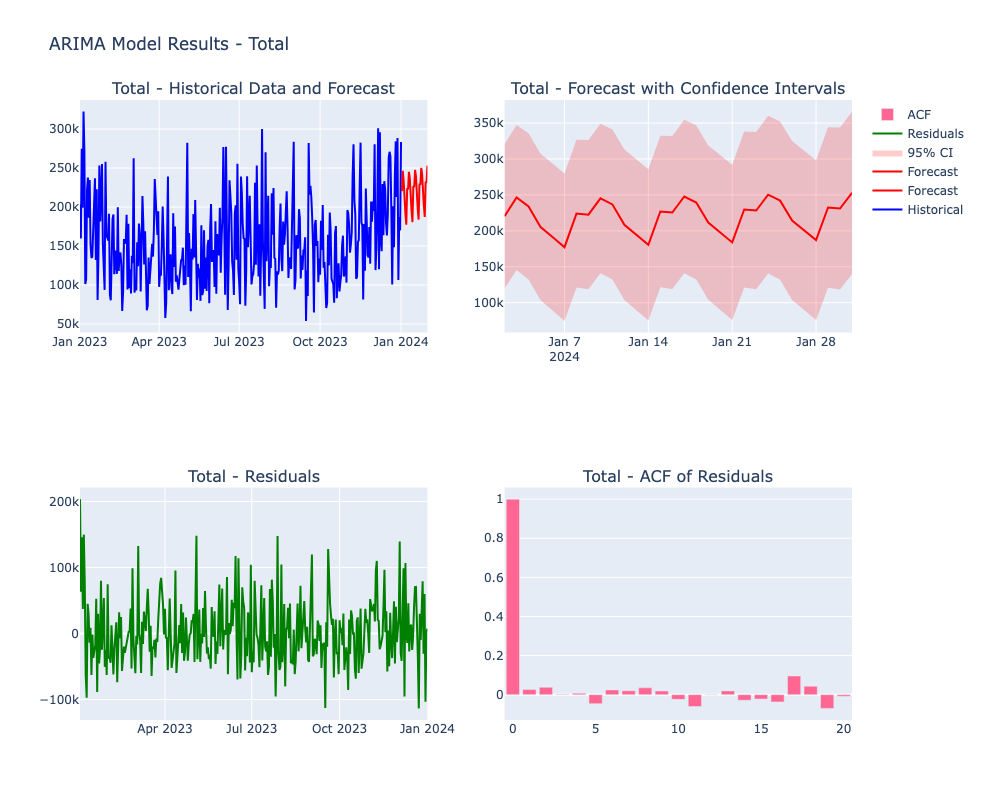

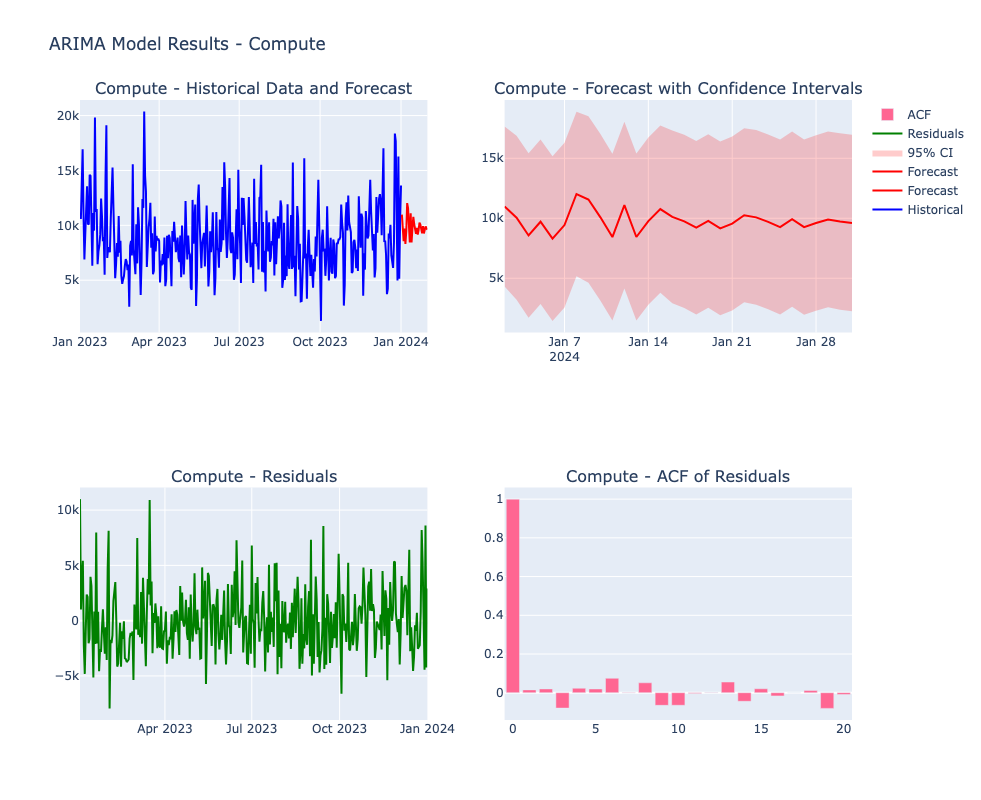

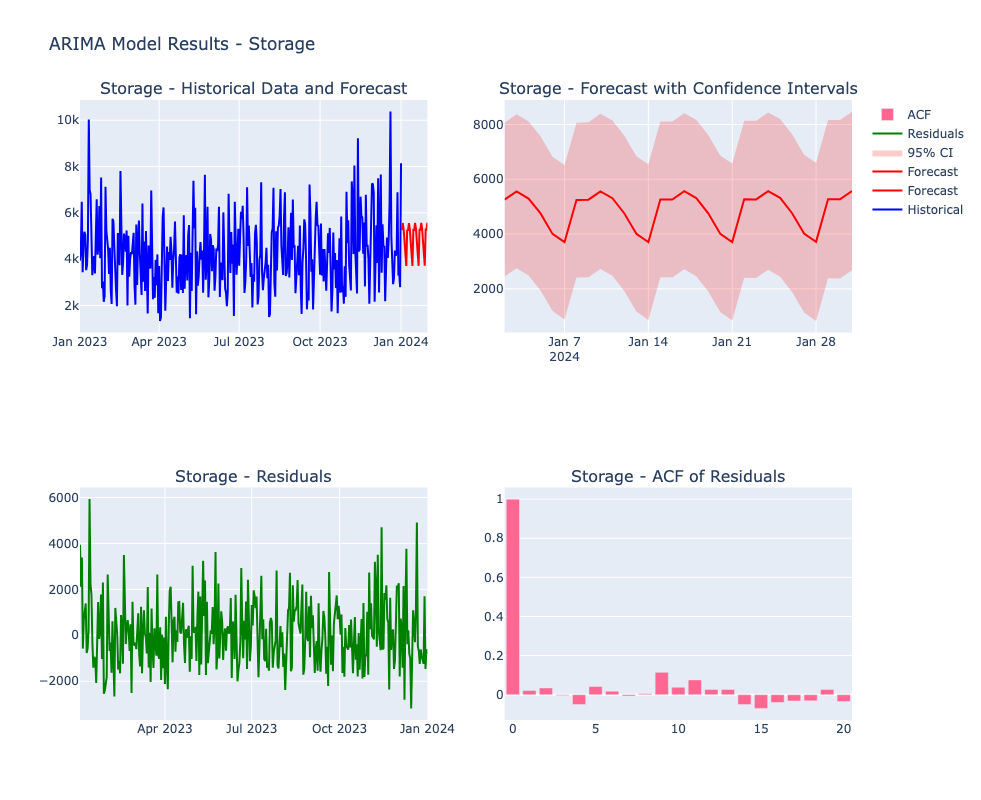

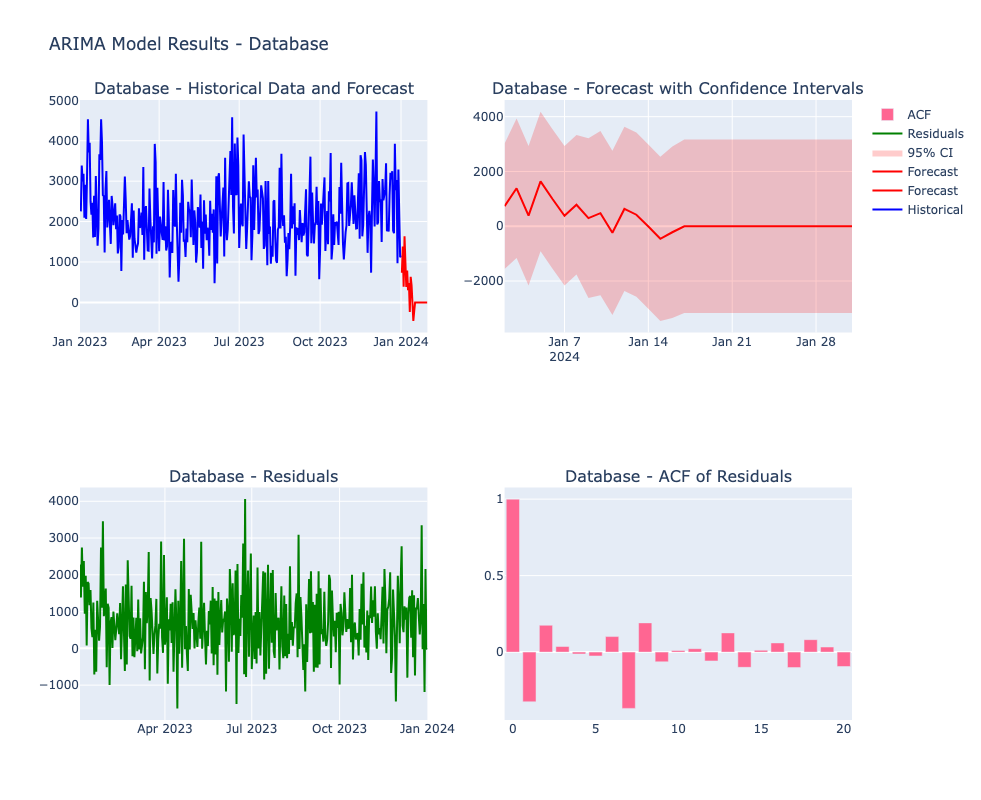

In [6]:
# Visualize ARIMA Results
def plot_arima_results(timeseries, forecast, conf_int, category_name, periods=30):
    """
    Create comprehensive visualizations for ARIMA model results.
    """
    # Create future dates
    last_date = timeseries.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods, freq='D')
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            f'{category_name} - Historical Data and Forecast',
            f'{category_name} - Forecast with Confidence Intervals',
            f'{category_name} - Residuals',
            f'{category_name} - ACF of Residuals'
        ),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # 1. Historical data and forecast
    fig.add_trace(
        go.Scatter(x=timeseries.index, y=timeseries.values, mode='lines',
                  name='Historical', line=dict(color='blue')),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=future_dates, y=forecast, mode='lines',
                  name='Forecast', line=dict(color='red')),
        row=1, col=1
    )
    
    # 2. Forecast with confidence intervals
    fig.add_trace(
        go.Scatter(x=future_dates, y=forecast, mode='lines',
                  name='Forecast', line=dict(color='red')),
        row=1, col=2
    )
    
    # Add confidence intervals
    fig.add_trace(
        go.Scatter(x=future_dates, y=conf_int.iloc[:, 1], 
                  mode='lines', line=dict(width=0), showlegend=False),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Scatter(x=future_dates, y=conf_int.iloc[:, 0], 
                  mode='lines', line=dict(width=0), fill='tonexty',
                  fillcolor='rgba(255,0,0,0.2)', name='95% CI'),
        row=1, col=2
    )
    
    # 3. Residuals
    if category_name in model_diagnostics:
        residuals = model_diagnostics[category_name]['residuals']
        fig.add_trace(
            go.Scatter(x=timeseries.index[1:], y=residuals, mode='lines',
                      name='Residuals', line=dict(color='green')),
            row=2, col=1
        )
    
    # 4. ACF of residuals
    if category_name in model_diagnostics:
        residuals = model_diagnostics[category_name]['residuals']
        from statsmodels.tsa.stattools import acf
        acf_values = acf(residuals, nlags=20)
        lags = range(len(acf_values))
        
        fig.add_trace(
            go.Bar(x=list(lags), y=acf_values, name='ACF'),
            row=2, col=2
        )
    
    fig.update_layout(height=800, title_text=f"ARIMA Model Results - {category_name}")
    fig.show()

# Create visualizations for each model
for category, result in arima_results.items():
    ts_data = stationarity_results[category]['original']
    plot_arima_results(
        ts_data, 
        result['forecast'], 
        result['conf_int'], 
        category, 
        forecast_periods
    )


In [ ]:
# Save ARIMA Results
print("=== Saving ARIMA Results ===")

# Save models and results
import joblib
import os

# Create results directory
results_dir = '/Users/sabbineni/projects/acm/results/arima'
os.makedirs(results_dir, exist_ok=True)

# Save models
for category, result in arima_results.items():
    model_path = f"{results_dir}/arima_model_{category.lower()}.pkl"
    joblib.dump(result['model'], model_path)
    print(f"Saved model: {model_path}")

# Save forecasts
for category, result in arima_results.items():
    # Create forecast DataFrame
    last_date = stationarity_results[category]['original'].index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                periods=forecast_periods, freq='D')
    
    forecast_df = pd.DataFrame({
        'date': future_dates,
        'forecast': result['forecast'],
        'lower_bound': result['conf_int'].iloc[:, 0],
        'upper_bound': result['conf_int'].iloc[:, 1]
    })
    
    forecast_path = f"{results_dir}/arima_forecast_{category.lower()}.csv"
    forecast_df.to_csv(forecast_path, index=False)
    print(f"Saved forecast: {forecast_path}")

# Save model parameters and diagnostics
params_df = pd.DataFrame(best_params).T
params_path = f"{results_dir}/arima_parameters.csv"
params_df.to_csv(params_path)
print(f"Saved parameters: {params_path}")

# Save diagnostics
if model_diagnostics:
    diagnostics_path = f"{results_dir}/arima_diagnostics.pkl"
    joblib.dump(model_diagnostics, diagnostics_path)
    print(f"Saved diagnostics: {diagnostics_path}")

# Create forecast comparison
forecast_comparison = pd.DataFrame()
for category, result in arima_results.items():
    last_date = stationarity_results[category]['original'].index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                periods=forecast_periods, freq='D')
    forecast_comparison[category] = result['forecast'].values

forecast_comparison.index = future_dates
forecast_comparison.index.name = 'Date'

comparison_path = f"{results_dir}/arima_forecast_comparison.csv"
forecast_comparison.to_csv(comparison_path)
print(f"Saved forecast comparison: {comparison_path}")

print("\n✅ ARIMA model implementation completed successfully!")
print("📊 Models trained, evaluated, and saved")
print("🔮 Future forecasts generated for 30 days")
print("📈 Results ready for comparison with other models")
